# Startup success

Our [task](https://github.com/Metricam/Internship_tasks/tree/master/Startup_Success) is to analyze and reveal the reasons behind the success/failure of the given startups.

We will primarily use two approaches to solve the problem by leveraging `sklearn`'s mutual info model and `catboost`'s functionality.

## Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Metricam/Internship_tasks/master/Startup_Success/data.csv', encoding='latin1')

In [3]:
df.head()

,Company_Name,Dependent-Company Status,year of founding,Age of company in years,Internet Activity Score,Short Description of company profile,Industry of company,Focus functions of company,Investors,Employee Count,...,Percent_skill_Data Science,Percent_skill_Business Strategy,Percent_skill_Product Management,Percent_skill_Sales,Percent_skill_Domain,Percent_skill_Law,Percent_skill_Consulting,Percent_skill_Finance,Percent_skill_Investment,Renown score
0,Company1,Success,No Info,No Info,-1.0,Video distribution,NaN,operation,KPCB Holdings|Draper Fisher Jurvetson (DFJ)|Kl...,3.0,...,0,0,0,0,0,0,0,0,0,0
1,Company2,Success,2011,3,125.0,NaN,Market Research|Marketing|Crowdfunding,"Marketing, sales",NaN,NaN,...,8.823529412,21.76470588,10.88235294,2.941176471,0,0,0,0,0,8
2,Company3,Success,2011,3,455.0,Event Data Analytics API,Analytics|Cloud Computing|Software Development,operations,TechStars|Streamlined Ventures|Amplify Partner...,14.0,...,3.846153846,17.09401709,9.401709402,0,2.777777778,0,0,0,0,9
3,Company4,Success,2009,5,-99.0,The most advanced analytics for mobile,Mobile|Analytics,Marketing & Sales,Michael Birch|Max Levchin|Sequoia Capital|Keit...,45.0,...,0,0,0,0,0,0,0,0,0,5
4,Company5,Success,2010,4,496.0,The Location-Based Marketing Platform,Analytics|Marketing|Enterprise Software,Marketing & Sales,DFJ Frontier|Draper Nexus Ventures|Gil Elbaz|A...,39.0,...,0,0,0,0,0,0,0,0,0,6


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472 entries, 0 to 471
Columns: 116 entries, Company_Name to Renown score
dtypes: float64(5), int64(3), object(108)
memory usage: 427.9+ KB


In [5]:
int_columns = df.select_dtypes(include='int').columns
float_columns = df.select_dtypes(include='float').columns
object_columns = df.select_dtypes(include='object').columns
date_columns = ['Est. Founding Date',
                'Last Funding Date']

In [6]:
for col in date_columns:
    df[col] = pd.to_datetime(df[col], format='%m/%d/%Y')
    df[col + ' year'] = df[col].dt.year
    df[col + ' month'] = df[col].dt.month
    df[col + ' day'] = df[col].dt.day

date_features = []
for ft in date_columns:
    date_features += [ft + ' year', ft + ' month', ft + ' day']

Some object columns are in fact numeric. Let's convert them to the correct dtype replacing the omitted values by the mean of present values.

In [7]:
numeric_columns = []

for col in object_columns:
    numeric_series = pd.to_numeric(df[col], errors='coerce')
    if numeric_series.notnull().any():
        numeric_columns.append(col)

for col in [*numeric_columns, *int_columns, *float_columns, *date_features]:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    mean_value = df[col].mean()
    df[col] = pd.to_numeric(df[col].fillna(mean_value))

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472 entries, 0 to 471
Columns: 122 entries, Company_Name to Last Funding Date day
dtypes: float64(45), int64(5), object(72)
memory usage: 450.0+ KB


Some features need to be cleaned:

In [9]:
features_to_clean = ['Has the team size grown',
                     'Number of  Sales Support material',
                     'Cloud or platform based serive/product?',
                     'Local or global player']

for ft in features_to_clean:
    print(ft, df[ft].unique(), sep='\n', end='\n\n')

Has the team size grown
['No' 'Yes' 'yes' 'No Info' 'YES' nan]

Number of  Sales Support material
['Nothing' 'medium' 'low' 'high' 'High' 'No Info']

Cloud or platform based serive/product?
['Platform' 'cloud' 'Cloud' 'none' 'Both' 'No Info']

Local or global player
['Global' 'Local' 'local' 'global' 'GLOBAL' 'LOCAL' 'No Info' 'GLObaL'
 'local  ']



In [10]:
for ft in features_to_clean:
    df[ft] = df[ft].astype('str').apply(lambda x: x.strip().lower())

In [11]:
unimportant_features = [*date_columns, 'Dependent-Company Status', 'Company_Name']

textual_features = ['Short Description of company profile',
                    'Industry of company',
                    'Focus functions of company',
                    'Investors',
                    'Specialization of highest education']

numerical_features = df.select_dtypes(include=['float', 'int']).columns.tolist()
# numerical_features += date_features

categorical_features = df.drop([*unimportant_features, *textual_features], axis=1).select_dtypes(include='object').columns.tolist()

target = 'Dependent-Company Status'

In [12]:
for ft in categorical_features:
    df[ft] = df[ft].astype('category')
    df[ft] = df[ft].cat.add_categories(['missing'])
    df[ft] = df[ft].fillna('missing')

df[target] = df[target].astype('category')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472 entries, 0 to 471
Columns: 122 entries, Company_Name to Last Funding Date day
dtypes: category(66), float64(45), int64(5), object(6)
memory usage: 250.9+ KB


## Feature engineering

We need to process textual columns to extract useful features out of them. To this end we will vectorize these columns by tf-idf and clusterize them. Clusters will encode semantic information about these text columns.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

In [15]:
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    # Removing punctuation
    tokens = [word for word in tokens if word not in string.punctuation]
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [16]:
clustered_textual_features = []

for ft in textual_features:
    df[ft] = df[ft].astype(str)
    df[ft] = df[ft].apply(preprocess_text)
    
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df[ft])

    num_clusters = 15
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(X)

    df[f'{ft}_cluster_label'] = kmeans.labels_
    clustered_textual_features.append(f'{ft}_cluster_label')

categorical_features += clustered_textual_features
categorical_features = [ft for ft in categorical_features if ft not in textual_features]

In [17]:
df[clustered_textual_features].head()

,Short Description of company profile_cluster_label,Industry of company_cluster_label,Focus functions of company_cluster_label,Investors_cluster_label,Specialization of highest education_cluster_label
0,11,1,0,13,3
1,1,12,12,1,1
2,5,6,0,12,13
3,14,14,10,10,1
4,10,2,10,2,1


Henceforth we will use only the following features:

In [18]:
important_features = [*numerical_features, *categorical_features]

## Mutual information

In [19]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import mutual_info_classif

In [20]:
ordinal_encoder = OrdinalEncoder()

df_mi = df.copy()
df_mi[categorical_features] = ordinal_encoder.fit_transform(df[categorical_features])
df_mi[target] = ordinal_encoder.fit_transform(df[target].to_frame())

In [21]:
mi = mutual_info_classif(df_mi[important_features],
                         df_mi[target])

In [22]:
def make_scores(features, importances, name):
    return pd.Series(importances, name=name, index=features).sort_values(ascending=False)

def plot_scores(scores, name, color, top_k=30):
    plt.figure(figsize=(10, 2 + top_k / 5))
    width = np.arange(top_k)
    ticks = list(scores[:top_k].index)
    plt.barh(width, scores[:top_k], color=color)
    plt.yticks(width, ticks)
    plt.xlabel('Importances')
    plt.ylabel('Features')
    plt.title(f"Top {top_k} {name} scores")
    plt.gca().invert_yaxis()
    plt.show()

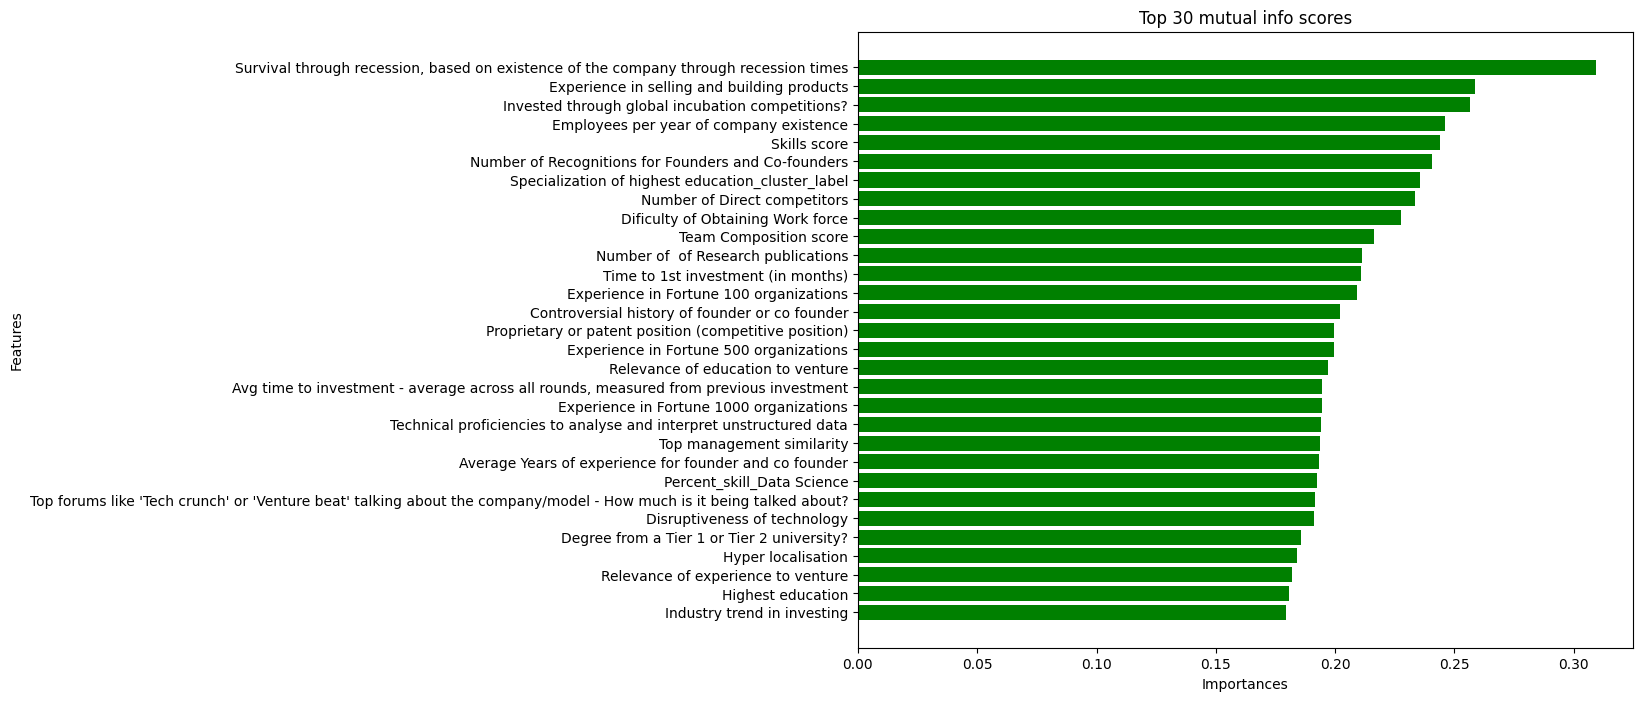

In [23]:
mi_scores = make_scores(important_features, mi, name='mutual info scores')
plot_scores(mi_scores, name='mutual info', color='green')

## Using catboost

Mutual info can be measured only between two random variables, in our case between one feature and the target. However there might be features that have little effect on the target if considered solely by themselves, but can have great impact on the target if taken into account in combination with each other.

To evade this problem we will use catboost. We will feed the data to catboost and get the feature importances. Note that since we are not solving a prediction problem we will not need to tune hyperparameters.

In [24]:
from catboost import CatBoostClassifier, Pool

In [25]:
train_pool = Pool(
    data=df[important_features],
    label=df[target],
    cat_features=categorical_features)

In [26]:
model = CatBoostClassifier(iterations=215, depth=5, learning_rate=0.19,
                           loss_function='Logloss', early_stopping_rounds=50, verbose=False)

In [27]:
model.fit(train_pool)

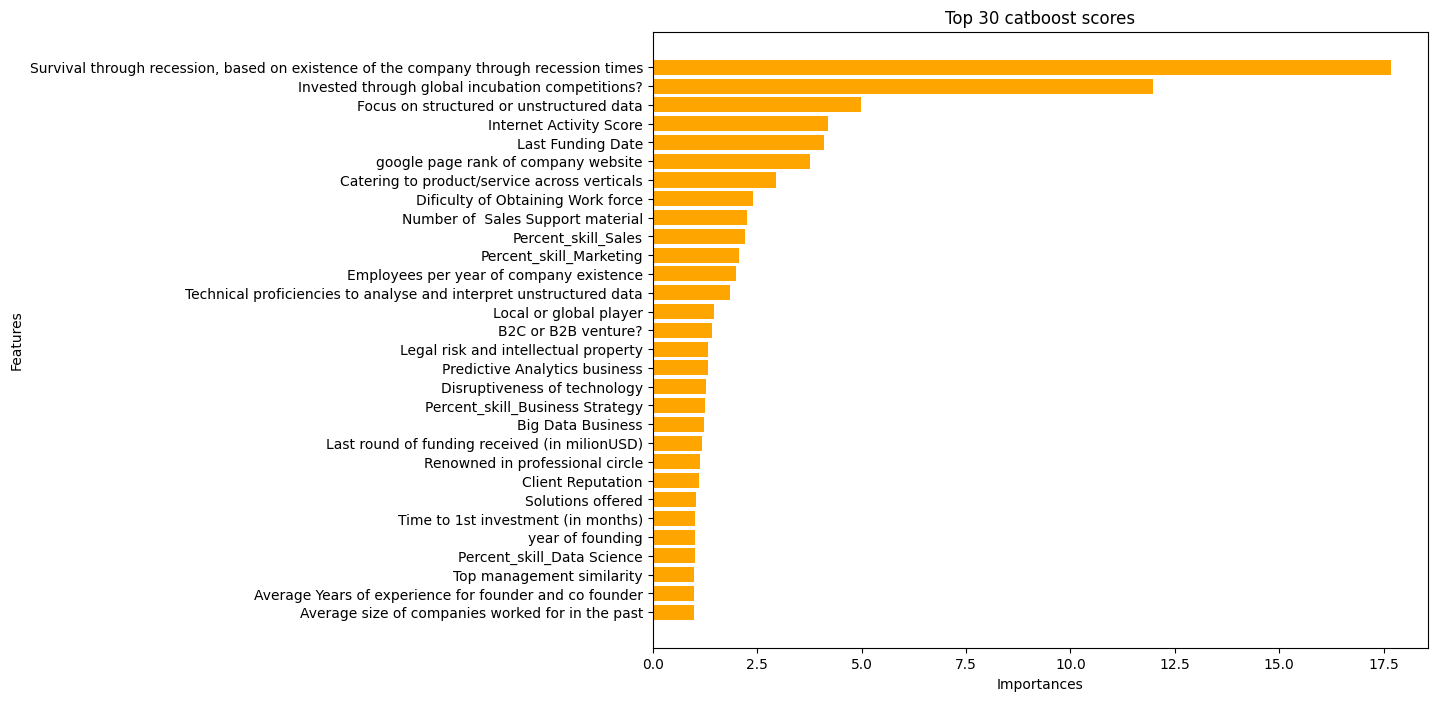

In [28]:
cb_scores = make_scores(important_features,
                        model.get_feature_importance(),
                        name='catboost scores')
plot_scores(cb_scores, name='catboost', color='orange')

## Results

Let's take a look at the features identified as the most crucial for success by both mutual info classification and catboost:

In [29]:
top_features = list(set(mi_scores[:30].index) & set(cb_scores[:30].index))
top_features

['Percent_skill_Data Science',
 'Invested through global incubation competitions?',
 'Dificulty of Obtaining Work force',
 'Employees per year of company existence',
 'Average Years of experience for founder and co founder',
 'Disruptiveness of technology',
 'Survival through recession, based on existence of the company through recession times',
 'Top management similarity',
 'Technical proficiencies to analyse and interpret unstructured data',
 'Time to 1st investment (in months)']

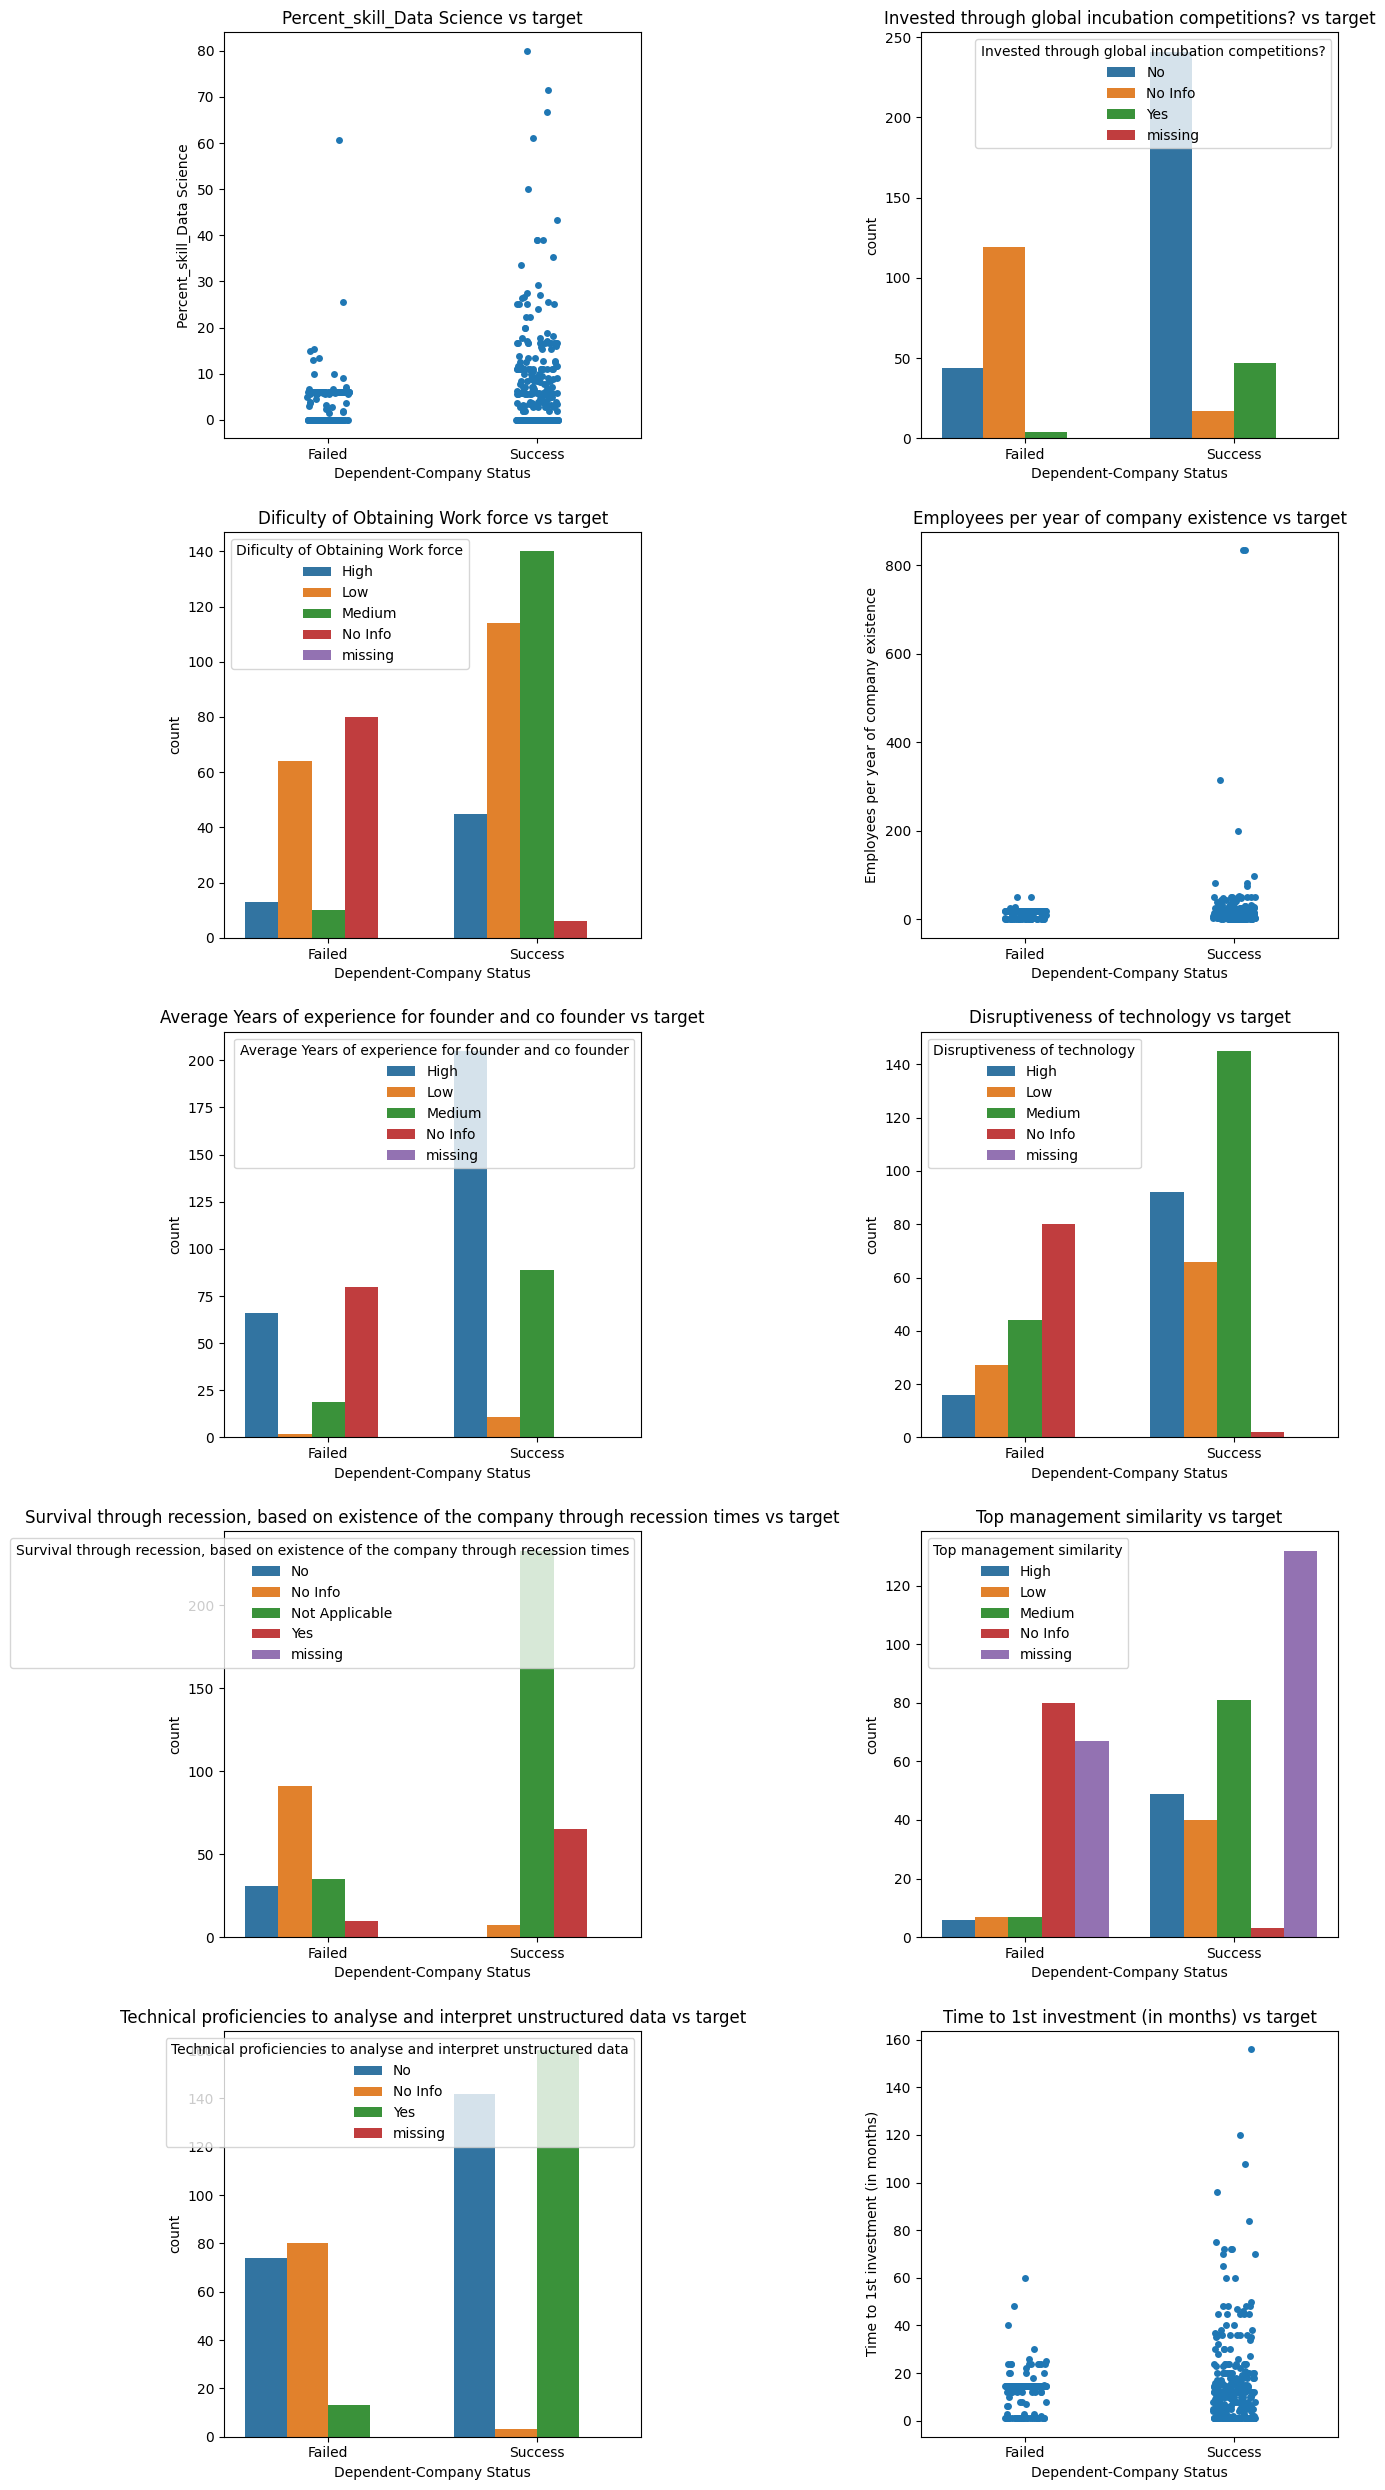

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

num_plots = len(top_features)
num_rows = (num_plots + 1) // 2

fig, axes = plt.subplots(num_rows, 2, figsize=(12, 5*num_rows))

for i, ft in enumerate(top_features):
    row = i // 2
    col = i % 2
    if df[ft].dtype == 'category':
        sns.countplot(x=target, hue=ft, data=df, ax=axes[row, col])
    elif df[ft].dtype == 'float64':
        sns.stripplot(x=target, y=ft, data=df, ax=axes[row, col])
    axes[row, col].set_title(f'{ft} vs target')

plt.subplots_adjust(hspace=3.5)
plt.tight_layout()
plt.show()

As we see <span style="color:#c5f015">technical proficiencies</span> are really decisive for the company's success (see the blue and green columns).

Startups that have relatively low <span style="color:#c5f015">google page rank of company website</span> are obviously biased towards success. For higher ranked websites company success seems to become more random.

<span style="color:#c5f015">Average years of experience for founders</span> also significantly impact success (see the blue and green columns). Startups with founders' high or medium experience are prone to success.

Startups with low or medium <span style="color:#c5f015">difficulty of obtaining workforce</span> generally succeed.

Success dominates among startups not <span style="color:#c5f015">invested through global incubation competitions</span>.

As we see on the <span style="color:#c5f015">survival through recession</span> graph, succeeded companies tend to not have experienced such periods (see the green column).

## Miscellaneous

An alternative approach could be taken when processing textual columns by using a pretrained embedding:

In [31]:
# import spacy
# from sklearn.decomposition import PCA

# nlp = spacy.load("en_core_web_md")

# def compute_embeddings(text):
#     doc = nlp(text)
#     return doc.vector

# for ft in textual_features:
#     df[ft] = df[ft].astype(str)
#     embeddings = df[ft].apply(compute_embeddings)
# embedding_array = np.array(embeddings.tolist())

# n_components = min(5, min(embedding_array.shape))  # Minimum of 5 and the number of features (dimensions)

# pca = PCA(n_components=n_components)
# embeddings_reduced = pca.fit_transform(embedding_array)

# # Create DataFrame with reduced embeddings
# embedding_df = pd.DataFrame(embeddings_reduced, columns=[f"dim_{i+1}" for i in range(n_components)])

# # # Concatenate embeddings with original DataFrame
# # df_with_low_dim_embeddings = pd.concat([df, embedding_df], axis=1)
# # print(df_with_low_dim_embeddings)

# embedding_df.head()